In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('../peptidome.mplstyle')
plt.style.use('talk')

import sys
sys.path.append('..')

from lib import *

In [2]:
def nndist_probability(k, N):
    K = 20**k
    d = np.arange(0, k+1)
    Nc = lambda d: 19**d * falling_factorial(k, d+1)
    Ncs = Nc(d)
    cumulative = [0]
    cumulative.extend(1-np.exp(-np.cumsum(Ncs)*N/K))
    p = np.diff(cumulative)
    return d, p

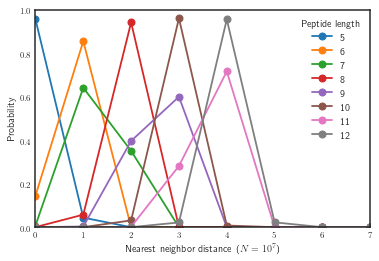

In [3]:
fig, ax = plt.subplots()
N = 1e7
for k in range(5, 13):
    d, p = nndist_probability(k, N)
    ax.plot(d, p, '-o', label=k)
ax.set_ylim(0, 1)
ax.legend(title='Peptide length')
ax.set_xlim(0, 7)
ax.set_ylabel('Probability')
ax.set_xlabel('Nearest neighbor distance ($N=10^{ %g }$)'%np.log10(N))
fig.savefig('main.png')

# Neighbor density

## check summation formula

In [13]:
def neighbors(sigma, S):
    for i in range(len(sigma)):
        for s in range(S):
            if not sigma[i] == s:
                yield np.asarray(list(sigma[:i]) + [s] + list(sigma[i+1:]))

S = 2
k = 2
sigma_lognormal = 1.0
pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
pi /= pi.sum()
sigma = np.random.randint(0, S, k)
nsigma = np.prod(pi[sigma])*np.sum((1-pi[sigma])/pi[sigma])
nsigma_sum = np.sum(np.prod(pi[sigmap]) for sigmap in neighbors(sigma, S))
print(nsigma, nsigma_sum)

0.6429878735815814 0.6429878735815815


/home/amayer/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


## generate samples from P_uniform(psigma, nsigma)

In [40]:
S = 20
k = 5

Nn = k*(S-1)
N = S**k

sigma_lognormal = 0.14
pi = np.random.lognormal(sigma=sigma_lognormal, size=S)
pi /= pi.sum()


psigmas = []
nsigmas = []
Nsample = 100000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    nsigma = np.prod(pi[sigma])*np.sum((1-pi[sigma])/pi[sigma])
    psigmas.append(psigma)
    nsigmas.append(nsigma)
nsigmas = np.asarray(nsigmas)
psigmas = np.asarray(psigmas)

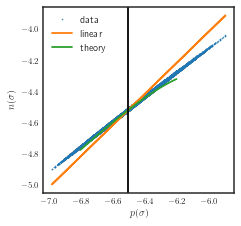

In [41]:
fig, ax = plt.subplots(figsize=(3.42, 3.42))
ax.plot(np.log10(psigmas), np.log10(nsigmas), '.', label='data', ms=1)
ax.plot(np.log10(psigmas), np.log10(psigmas)+np.log10(k*(S-1)), '-', label='linear')
psigmas_theory = np.linspace(0.5*S**(-k), 2*S**(-k))
ax.plot(np.log10(psigmas_theory), np.log10(psigmas_theory)+np.log10(k*(S-1)-S*(psigmas_theory*S**k-1)),
        '-', label='theory')
ax.axvline(-k*np.log10(S), c='k')
ax.set_xlabel('$p(\sigma)$')
ax.set_ylabel('$n(\sigma)$')
ax.legend()
fig.savefig('main_npcorr.png')

In [58]:
rho = np.corrcoef(psigmas, nsigmas)[1, 0]
print(r'$\rho_{p(\sigma), n(\sigma)}$:', rho)
slope, intercept = np.polyfit(np.log10(psigmas), np.log10(nsigmas), 1)
rho1 = 1 - S/(k*(S-1))
print('slope, prediction', slope, rho1)
nsigmavar_pred = np.var(psigmas)* Nn**2 * rho1**2
print('nsigmavar (sampled, upper, pred):',np.var(nsigmas), np.var(psigmas)*Nn**2, nsigmavar_pred)
nsigmabar = np.sum(nsigmas*psigmas/np.sum(psigmas))
nsigmabar_upper = Nn*np.mean(psigmas**2)*N
nsigmabar_pred = Nn/N + N*Nn*rho1*np.var(psigmas)
print('nsigmabar (sampled, upper, pred):', nsigmabar, nsigmabar_upper, nsigmabar_pred)

$\rho_{p(\sigma), n(\sigma)}$: 0.9981919120503897
slope, prediction 0.7977435077264051 0.7894736842105263
nsigmavar (sampled, upper, pred): 6.889340213581447e-11 1.1295437516780505e-10 7.040092635112503e-11
nsigmabar (sampled, upper, pred): 3.262588989003668e-05 3.3403891757206854e-05 3.2691272857648005e-05


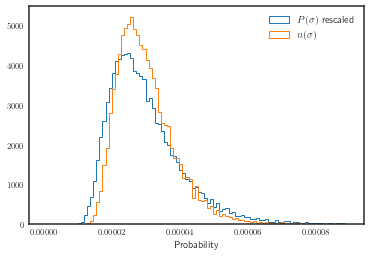

In [64]:
bins = np.linspace(0.0, max(nsigmas), 100)
fig, ax = plt.subplots()
ax.hist(psigmas*k*(S-1), bins=bins, histtype='step', label='$P(\sigma)$ rescaled')
ax.hist(nsigmas, bins=bins, histtype='step', label='$n(\sigma)$')
ax.legend()
ax.set_xlabel('Probability');

## correlation between probabilities

In [65]:
S = 20
sigma = 0.14
pi = np.random.lognormal(sigma=sigma, size=S)
pi /= pi.sum()
k = 5
psigmas = []
psigmaps = []
Nsample = 100000
for i in range(Nsample):
    sigma = np.random.randint(0, S, k)
    psigma = np.prod(pi[sigma])
    i = np.random.randint(0, k)
    sigmai = np.random.choice([s for s in range(0, S) if s != sigma[i]])
    sigmap = np.asarray(list(sigma[:i]) + [sigmai] + list(sigma[i+1:]))
    psigmap = np.prod(pi[sigmap])*np.sum((1-pi[sigmap])/pi[sigmap])
    psigmas.append(psigma)
    psigmaps.append(psigmap)
psigmaps = np.asarray(psigmaps)
psigmas = np.asarray(psigmas)

In [66]:
rhop = np.corrcoef(psigmaps, psigmas)[0, 1]
rhop, rho1**2

(0.7847621898786945, 0.6232686980609419)

## TODO

- Check these formulas!
- What about longer distances? (Second, third neighbours etc.?) Do things generalize?
- Test with rough Mount Fuji?